## Data Preprocessing for House Prices Competition 🛠️🏠

### 0. Preprocessing Roadmap

This notebook performs full preprocessing for the House Prices Kaggle competition. Below is the step-by-step structure:

1. **Imports & Setup**  
   Load all necessary libraries and set display options.

2. **Load Data**  
   Load the training dataset and make a backup copy.

3. **Drop Low-Information Features**  
   Remove features where a single value dominates (>98%).

4. **Handle Missing Values**  
   Fill missing values using contextual strategies:  
   - "NA" for structural categorical nulls  
   - `0` for structural numeric nulls  
   - Group-wise median for `LotFrontage`  
   - Mode for rare single NaNs like `Electrical`

5. **Binary Transformations**  
   Convert rare categorical flags (e.g. `PoolQC`, `Fence`) into binary indicators.

6. **Feature Engineering**  
   Create aggregated and meaningful new features (e.g. `TotalBath`, `HouseAge`, `TotalSF`).

7. **Remove Target Outliers**  
   Drop rows with `SalePrice > 500,000` before log transformation.

8. **Target Log Transformation**  
   Apply `log1p` to `SalePrice`; preserve original for comparison.

9. **Skew Correction for Features**  
   Apply `log1p` to highly skewed numeric features (|skew| > 1).

10. **Encoding & Scaling**  
    Define and apply transformers for numeric and categorical features using pipelines.

11. **Final Dataset Check**  
    Ensure no missing values remain and inspect sample structure.

12. **Visualization of SalePrice Distribution after Log Transformation**  
    Plot the transformed target distribution to verify normalization.

13. **Export Processed Dataset & Save Preprocessor**  
    Save cleaned data and export the fitted preprocessor with `joblib` for future use in modeling.

### 1. Setup

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Allow full display of all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### 2. Load Data

In [2]:
# Load the training dataset
df = pd.read_csv("../data/raw/train.csv")

### 3. Drop Low-Information Features

In [3]:
# Drop features with >98% the same value (little to no information gain)
low_info_cols = ["Street", "Utilities", "Condition2", "RoofMatl"]
df.drop(columns=low_info_cols, inplace=True)

### 4. Handle missing values


In [4]:
# Categorical features where "NA" means "Not Applicable"
cat_na = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageType",
          "GarageFinish", "GarageQual", "GarageCond", "BsmtQual", "BsmtCond",
          "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "MasVnrType"]
df[cat_na] = df[cat_na].fillna("NA")

# Numeric features where missing means zero
num_na = ["GarageYrBlt", "GarageArea", "GarageCars", "BsmtFinSF1", "BsmtFinSF2",
          "BsmtUnfSF", "BsmtHalfBath", "BsmtFullBath", "MasVnrArea"]
df[num_na] = df[num_na].fillna(0)

# Fill missing LotFrontage by neighborhood median
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# If any missing values remain in LotFrontage, fill with global median
if df["LotFrontage"].isna().sum() > 0:
    df["LotFrontage"] = df["LotFrontage"].fillna(df["LotFrontage"].median())
    
# Fill one missing value in Electrical with mode
df["Electrical"] = df["Electrical"].fillna(df["Electrical"].mode()[0])

### 5. Binary transformation

In [5]:
# Convert sparse categorical features into binary flags
df["HasPool"] = (df["PoolQC"] != "NA").astype(int)
df["HasMisc"] = (df["MiscFeature"] != "NA").astype(int)
df["HasAlley"] = (df["Alley"] != "NA").astype(int)
df["HasFence"] = (df["Fence"] != "NA").astype(int)
df["HasAltHeating"] = (df["Heating"] != "GasA").astype(int)

# Drop the originals after encoding
df.drop(columns=["PoolQC", "MiscFeature", "Alley", "Fence", "Heating"], inplace=True)

### 6. Feature engineering

In [6]:
# Age-related features
df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
df["RemodelAge"] = df["YrSold"] - df["YearRemodAdd"]
df["GarageAge"] = df["YrSold"] - df["GarageYrBlt"]

# Aggregated porch and area features
df["TotalPorchSF"] = df["OpenPorchSF"] + df["EnclosedPorch"] + df["3SsnPorch"] + df["ScreenPorch"]
df["TotalBath"] = df["FullBath"] + 0.5 * df["HalfBath"] + df["BsmtFullBath"] + 0.5 * df["BsmtHalfBath"]
df["TotalSF"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]

### 7. Remove target outliers

In [7]:
# Drop rows where SalePrice > 500000 (extreme outliers)
df = df[df["SalePrice"] <= 500000]

### 8. Target log transformation

In [8]:
# Save original SalePrice for reference
df["SalePrice_raw"] = df["SalePrice"]

# Apply log1p transformation to stabilize variance
df["SalePrice"] = np.log1p(df["SalePrice"])

### 9. Skew correction for features

In [9]:
# Apply log1p to highly skewed numeric features
skewed_feats = [
    "MiscVal", "PoolArea", "LotArea", "3SsnPorch", "LowQualFinSF", "KitchenAbvGr",
    "BsmtFinSF2", "ScreenPorch", "BsmtHalfBath", "EnclosedPorch", "MasVnrArea",
    "OpenPorchSF", "LotFrontage", "BsmtFinSF1", "WoodDeckSF", "TotalBsmtSF",
    "1stFlrSF", "GrLivArea", "BsmtUnfSF", "2ndFlrSF", "TotRmsAbvGrd", "HalfBath",
    "Fireplaces", "BsmtFullBath"
]

for col in skewed_feats:
    df[col] = np.log1p(df[col])

### 10. Encoding and scaling

In [10]:
# Define feature types explicitly
numeric_features = [
    "LotFrontage", "LotArea", "YearBuilt", "YearRemodAdd", "MasVnrArea",
    "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF",
    "2ndFlrSF", "LowQualFinSF", "GrLivArea", "BsmtFullBath", "BsmtHalfBath",
    "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd",
    "Fireplaces", "GarageYrBlt", "GarageCars", "GarageArea", "WoodDeckSF",
    "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea",
    "MiscVal", "TotalPorchSF", "TotalBath", "TotalSF", "HouseAge", "RemodelAge",
    "GarageAge"
]

categorical_features = [
    "MSZoning", "LotShape", "LandContour", "LotConfig", "LandSlope",
    "Neighborhood", "Condition1", "BldgType", "HouseStyle", "RoofStyle",
    "Exterior1st", "Exterior2nd", "MasVnrType", "ExterQual", "ExterCond",
    "Foundation", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
    "BsmtFinType2", "HeatingQC", "CentralAir", "Electrical", "KitchenQual",
    "Functional", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual",
    "GarageCond", "PavedDrive", "SaleType", "SaleCondition", "MoSold",
    "YrSold", "MSSubClass", "OverallQual", "OverallCond"
]

# Define preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

### 11. Final dataset check

In [11]:
# Check remaining missing values (if any)
missing_summary = df.isnull().sum()
missing_cols = missing_summary[missing_summary > 0]
if not missing_cols.empty:
    print("⚠️ Remaining missing values:")
    print(missing_cols)
else:
    print("✅ No missing values found.")

# Quick overview of dataset structure
print("\n📊 Dataset info:")
print(df.info())

# Show sample rows
print("\n🔎 Sample data:")
display(df.sample(5))

✅ No missing values found.

📊 Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 1451 entries, 0 to 1459
Data columns (total 84 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1451 non-null   int64  
 1   MSSubClass     1451 non-null   int64  
 2   MSZoning       1451 non-null   object 
 3   LotFrontage    1451 non-null   float64
 4   LotArea        1451 non-null   float64
 5   LotShape       1451 non-null   object 
 6   LandContour    1451 non-null   object 
 7   LotConfig      1451 non-null   object 
 8   LandSlope      1451 non-null   object 
 9   Neighborhood   1451 non-null   object 
 10  Condition1     1451 non-null   object 
 11  BldgType       1451 non-null   object 
 12  HouseStyle     1451 non-null   object 
 13  OverallQual    1451 non-null   int64  
 14  OverallCond    1451 non-null   int64  
 15  YearBuilt      1451 non-null   int64  
 16  YearRemodAdd   1451 non-null   int64  
 17  RoofStyle    

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,HasPool,HasMisc,HasAlley,HasFence,HasAltHeating,HouseAge,RemodelAge,GarageAge,TotalPorchSF,TotalBath,TotalSF,SalePrice_raw
1173,1174,50,RL,4.934474,9.799848,IR1,Bnk,Inside,Gtl,ClearCr,Norm,1Fam,1.5Fin,5,6,1946,1994,Gable,MetalSd,MetalSd,NA,0.000000,TA,TA,CBlock,TA,TA,No,Rec,5.030438,BLQ,6.152733,6.885510,7.377134,TA,Y,SBrkr,7.400621,6.879356,6.173786,8.034955,0.000000,0.0,3,0.000000,3,0.693147,Ex,2.564949,Maj1,0.693147,Gd,NA,0.0,NA,0,0,NA,NA,Y,4.812184,0.000000,0.00000,0.0,0.0,0.0,0.0,3,2007,WD,Normal,12.208575,0,0,0,1,0,61,13,2007.0,0,3.0,4205,200500
1022,1023,50,RM,3.970292,9.152711,Reg,Lvl,Inside,Gtl,OldTown,Norm,1Fam,1.5Fin,5,5,1930,1950,Gable,Wd Sdng,Wd Sdng,NA,0.000000,TA,TA,CBlock,TA,TA,No,LwQ,5.783825,Unf,0.000000,6.378426,6.816736,Gd,Y,FuseA,6.816736,5.820083,0.000000,7.130099,0.000000,0.0,1,0.000000,2,0.693147,TA,1.945910,Typ,0.000000,NA,Detchd,1957.0,Unf,1,160,Fa,Fa,Y,0.000000,0.000000,5.26269,0.0,0.0,0.0,0.0,3,2007,WD,Normal,11.373675,0,0,0,0,0,77,57,50.0,192,1.0,2160,87000
1401,1402,60,RL,4.143135,8.911395,IR1,Lvl,Inside,Gtl,Gilbert,Norm,1Fam,2Story,6,5,2004,2004,Gable,VinylSd,VinylSd,NA,0.000000,TA,TA,PConc,TA,TA,No,GLQ,6.633318,Unf,0.000000,4.394449,6.733402,Ex,Y,SBrkr,6.762730,6.593045,0.000000,7.374002,0.693147,0.0,2,0.693147,3,0.693147,TA,2.197225,Typ,0.693147,TA,Attchd,2004.0,Fin,2,398,TA,TA,Y,4.615121,4.330733,0.00000,0.0,0.0,0.0,0.0,4,2008,WD,Normal,12.170451,0,0,0,0,0,4,4,4.0,75,3.5,2432,193000
842,843,80,RL,4.418841,9.107310,Reg,Lvl,Inside,Gtl,NAmes,Norm,1Fam,SLvl,6,7,1966,1966,Gable,HdBoard,HdBoard,BrkFace,5.214936,TA,TA,CBlock,TA,TA,Gd,Rec,5.746203,ALQ,6.291569,5.624018,7.028201,TA,Y,SBrkr,7.061334,0.000000,0.000000,7.061334,0.693147,0.0,1,0.693147,3,0.693147,TA,1.945910,Typ,0.000000,NA,Attchd,1966.0,RFn,2,490,Gd,Gd,Y,0.000000,4.867534,0.00000,0.0,0.0,0.0,0.0,5,2008,WD,Normal,12.071975,0,0,0,1,0,42,42,42.0,129,2.5,2292,174900
1200,1201,20,RL,4.276666,9.143559,Reg,Lvl,Inside,Gtl,NAmes,Norm,1Fam,1Story,4,5,1970,1970,Gable,MetalSd,MetalSd,NA,0.000000,TA,TA,CBlock,TA,TA,No,Unf,0.000000,Unf,0.000000,6.762730,6.762730,Gd,Y,SBrkr,6.762730,0.000000,0.000000,6.762730,0.000000,0.0,1,0.000000,3,0.693147,TA,1.791759,Typ,0.000000,NA,Attchd,1972.0,Unf,1,280,TA,TA,Y,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,7,2006,Oth,Abnorml,11.661785,0,1,0,0,0,36,36,34.0,0,1.0,1728,116050


### 12. Visualization of SalePrice distribution after log transformation

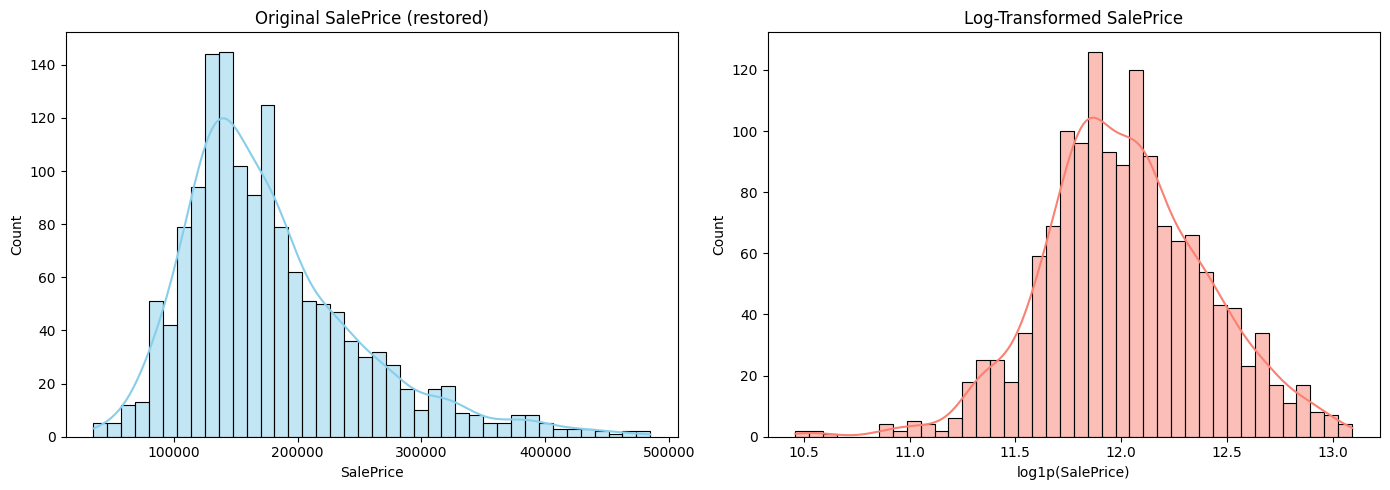

In [12]:
# Compare original and log-transformed target
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw SalePrice
sns.histplot(np.expm1(df["SalePrice"]), bins=40, kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("Original SalePrice (restored)")
axes[0].set_xlabel("SalePrice")

# Log-transformed SalePrice
sns.histplot(df["SalePrice"], bins=40, kde=True, ax=axes[1], color="salmon")
axes[1].set_title("Log-Transformed SalePrice")
axes[1].set_xlabel("log1p(SalePrice)")

plt.tight_layout()
plt.show()

### 13. Export processed dataset

In [14]:
output_path = "../data/processed"

# Save the preprocessed dataset
df.to_csv(os.path.join(output_path, "train_processed.csv"), index=False)

# Save the preprocessor
joblib.dump(preprocessor, "../results/preprocessor.pkl")

['../results/preprocessor.pkl']